# Features Dataset Exploration

This notebook explores the combined features dataset ready for XGBoost training.

**Features Info:**
- Source: Combined embeddings + labels + metadata from WildfireSpreadTS
- Format: CSV file with all features and targets
- Purpose: Ready for data splitting and model training

**Goals:**
1. Understand feature structure and composition
2. Analyze target variables (ignition, log_burned_area)
3. Explore feature distributions and correlations
4. Check data quality and class balance
5. Visualize relationships between features and targets


In [17]:
# Setup and imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Set paths
PROJECT_ROOT = Path().resolve().parent
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
FEATURES_PATH = PROCESSED_DIR / "features.csv"

print(f"Features path: {FEATURES_PATH}")
print(f"File exists: {FEATURES_PATH.exists()}")


Features path: C:\Users\muron\Documents\ml-wildfire-risk-predictor\data\processed\features.csv
File exists: True


## 1. Load Features


In [18]:
# Load features
if FEATURES_PATH.exists():
    print("Loading features...")
    df = pd.read_csv(FEATURES_PATH)
    print(f"✓ Loaded {len(df):,} rows")
    print(f"✓ {len(df.columns)} columns")
else:
    print(f"⚠️  Features file not found: {FEATURES_PATH}")
    print("Please run: python src/data/prepare_wildfirespreadts_features.py")


Loading features...
✓ Loaded 1,120 rows
✓ 2083 columns


## 2. Dataset Structure


In [19]:
# Display basic info
print("="*70)
print("DATASET OVERVIEW")
print("="*70)
print(f"Shape: {df.shape}")
print(f"\nColumn types:")
print(df.dtypes.value_counts())

print(f"\n" + "="*70)
print("COLUMN CATEGORIES")
print("="*70)

# Categorize columns
embedding_cols = [c for c in df.columns if c.startswith('embedding_')]
target_cols = [c for c in df.columns if c in ['ignition', 'burned_area', 'log_burned_area']]
metadata_cols = [c for c in df.columns if c in ['filename', 'date', 'event_id', 'tile', 'matched']]
temporal_cols = [c for c in df.columns if c in ['year', 'month', 'day_of_year', 'day_of_week']]
other_cols = [c for c in df.columns if c not in embedding_cols + target_cols + metadata_cols + temporal_cols]

print(f"Embedding columns: {len(embedding_cols)}")
print(f"Target columns: {target_cols}")
print(f"Metadata columns: {metadata_cols}")
print(f"Temporal columns: {temporal_cols}")
print(f"Other columns: {other_cols}")

print(f"\nFirst 10 columns: {list(df.columns[:10])}")
print(f"Last 10 columns: {list(df.columns[-10:])}")


DATASET OVERVIEW
Shape: (1120, 2083)

Column types:
float64    2075
int64         5
object        2
bool          1
Name: count, dtype: int64

COLUMN CATEGORIES
Embedding columns: 2048
Target columns: ['ignition', 'burned_area', 'log_burned_area']
Metadata columns: ['filename', 'date', 'event_id', 'tile', 'matched']
Temporal columns: ['year', 'month', 'day_of_year', 'day_of_week']
Other columns: ['tif_band_1', 'tif_band_2', 'tif_band_3', 'tif_band_4', 'tif_band_5', 'tif_band_6', 'tif_band_7', 'tif_band_8', 'tif_band_9', 'tif_band_10', 'tif_band_11', 'tif_band_12', 'tif_band_13', 'tif_band_14', 'tif_band_15', 'tif_band_16', 'tif_band_17', 'tif_band_18', 'tif_band_19', 'tif_band_20', 'tif_band_21', 'tif_band_22', 'tif_band_23']

First 10 columns: ['filename', 'date', 'event_id', 'tile', 'embedding_0', 'embedding_1', 'embedding_2', 'embedding_3', 'embedding_4', 'embedding_5']
Last 10 columns: ['tif_band_19', 'tif_band_20', 'tif_band_21', 'tif_band_22', 'tif_band_23', 'log_burned_area', 'y

## 3. Target Variables Analysis


In [20]:
# Analyze target variables
print("="*70)
print("TARGET VARIABLES ANALYSIS")
print("="*70)

# P-model target: ignition (binary)
if 'ignition' in df.columns:
    print(f"\n1. IGNITION (P-model target - Binary Classification):")
    print(f"   Total samples: {len(df):,}")
    print(f"   Ignition = 1: {df['ignition'].sum():,} ({df['ignition'].mean()*100:.2f}%)")
    print(f"   Ignition = 0: {(df['ignition'] == 0).sum():,} ({(df['ignition'] == 0).mean()*100:.2f}%)")
    print(f"   Class imbalance ratio: {(df['ignition'] == 0).sum() / df['ignition'].sum():.2f}:1")
    
    if df['ignition'].mean() < 0.01:
        print(f"   ⚠️  Highly imbalanced! Consider class weights or resampling.")
    elif df['ignition'].mean() < 0.05:
        print(f"   ⚠️  Imbalanced dataset. Consider class weights.")
    else:
        print(f"   ✓ Reasonable class balance")
else:
    print("⚠️  'ignition' column not found")

# A-model target: log_burned_area (continuous)
if 'log_burned_area' in df.columns:
    print(f"\n2. LOG_BURNED_AREA (A-model target - Regression):")
    print(f"   Mean: {df['log_burned_area'].mean():.4f}")
    print(f"   Std: {df['log_burned_area'].std():.4f}")
    print(f"   Min: {df['log_burned_area'].min():.4f}")
    print(f"   Max: {df['log_burned_area'].max():.4f}")
    print(f"   Median: {df['log_burned_area'].median():.4f}")
    print(f"   25th percentile: {df['log_burned_area'].quantile(0.25):.4f}")
    print(f"   75th percentile: {df['log_burned_area'].quantile(0.75):.4f}")
    
    # Check for zero values (no fire)
    zero_count = (df['log_burned_area'] == 0).sum()
    print(f"   Zero values (no fire): {zero_count:,} ({zero_count/len(df)*100:.2f}%)")
else:
    print("⚠️  'log_burned_area' column not found")

# Burned area (original, before log transform)
if 'burned_area' in df.columns:
    print(f"\n3. BURNED_AREA (Original, before log transform):")
    print(f"   Mean: {df['burned_area'].mean():.4f}")
    print(f"   Std: {df['burned_area'].std():.4f}")
    print(f"   Min: {df['burned_area'].min():.4f}")
    print(f"   Max: {df['burned_area'].max():.4f}")
    print(f"   Non-zero values: {(df['burned_area'] > 0).sum():,}")


TARGET VARIABLES ANALYSIS

1. IGNITION (P-model target - Binary Classification):
   Total samples: 1,120
   Ignition = 1: 522 (46.61%)
   Ignition = 0: 598 (53.39%)
   Class imbalance ratio: 1.15:1
   ✓ Reasonable class balance

2. LOG_BURNED_AREA (A-model target - Regression):
   Mean: 7.2036
   Std: 1.7993
   Min: 0.0000
   Max: 8.5884
   Median: 7.6540
   25th percentile: 7.2988
   75th percentile: 7.9097
   Zero values (no fire): 33 (2.95%)

3. BURNED_AREA (Original, before log transform):
   Mean: 2112.8814
   Std: 972.0547
   Min: 0.0000
   Max: 5368.2549
   Non-zero values: 1,087


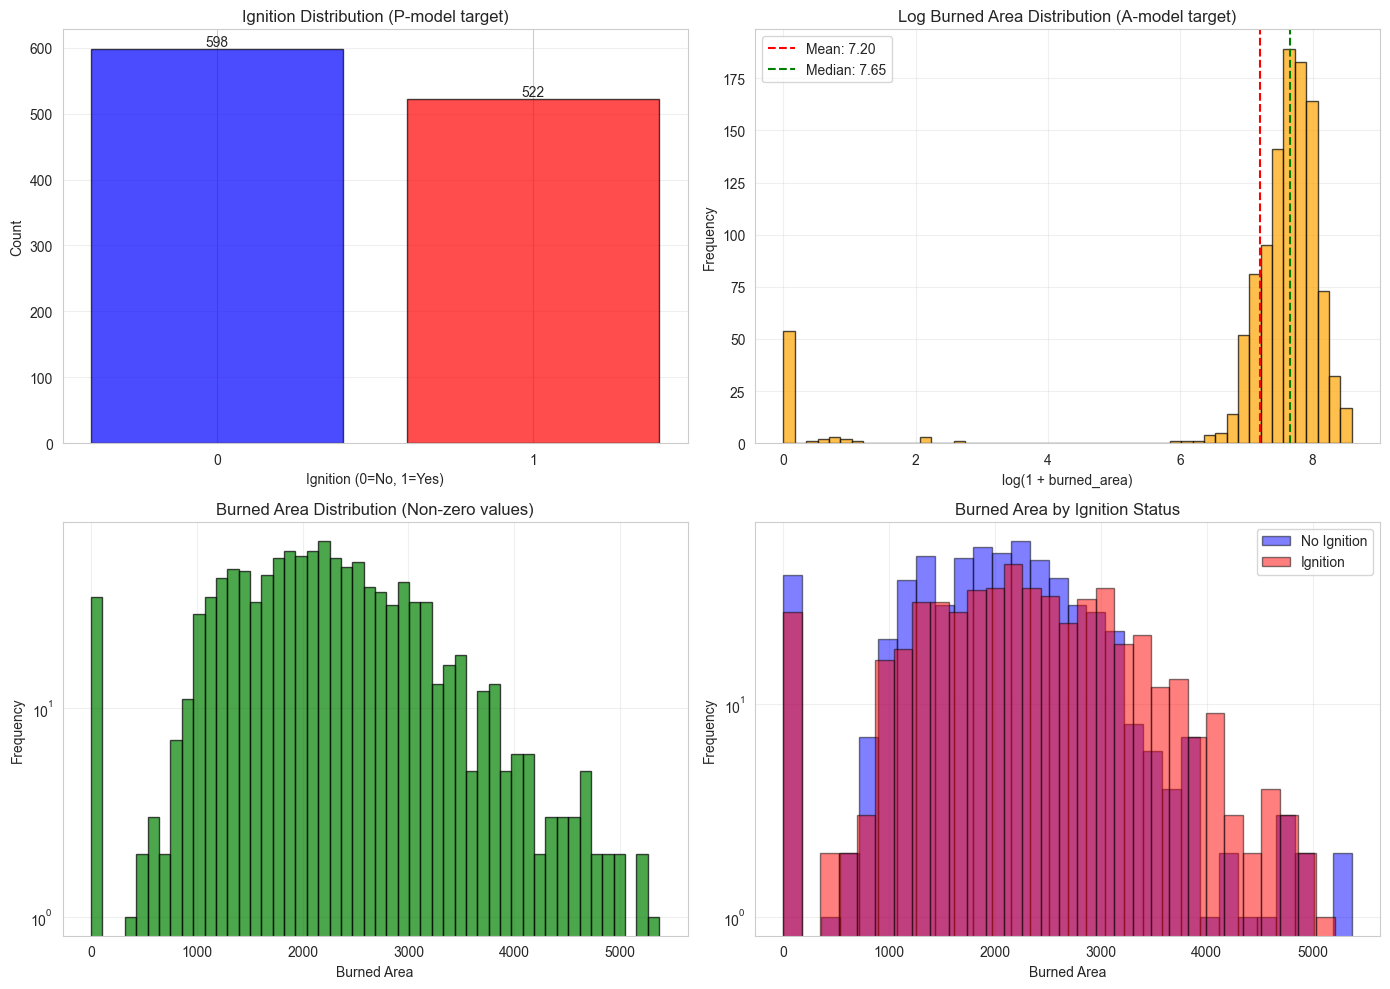

In [21]:
# Target variable distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Ignition distribution
if 'ignition' in df.columns:
    ignition_counts = df['ignition'].value_counts().sort_index()
    axes[0, 0].bar(ignition_counts.index, ignition_counts.values, alpha=0.7, edgecolor='black', color=['blue', 'red'])
    axes[0, 0].set_title('Ignition Distribution (P-model target)')
    axes[0, 0].set_xlabel('Ignition (0=No, 1=Yes)')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].set_xticks([0, 1])
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    for i, v in enumerate(ignition_counts.values):
        axes[0, 0].text(i, v, f'{v:,}', ha='center', va='bottom')

# Log burned area distribution
if 'log_burned_area' in df.columns:
    axes[0, 1].hist(df['log_burned_area'], bins=50, alpha=0.7, edgecolor='black', color='orange')
    axes[0, 1].set_title('Log Burned Area Distribution (A-model target)')
    axes[0, 1].set_xlabel('log(1 + burned_area)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Add statistics
    mean_val = df['log_burned_area'].mean()
    median_val = df['log_burned_area'].median()
    axes[0, 1].axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
    axes[0, 1].axvline(median_val, color='green', linestyle='--', label=f'Median: {median_val:.2f}')
    axes[0, 1].legend()

# Burned area distribution (original)
if 'burned_area' in df.columns:
    # Log scale for better visualization
    burned_area_nonzero = df[df['burned_area'] > 0]['burned_area']
    if len(burned_area_nonzero) > 0:
        axes[1, 0].hist(burned_area_nonzero, bins=50, alpha=0.7, edgecolor='black', color='green')
        axes[1, 0].set_title('Burned Area Distribution (Non-zero values)')
        axes[1, 0].set_xlabel('Burned Area')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].set_yscale('log')
        axes[1, 0].grid(True, alpha=0.3)

# Relationship between ignition and burned area
if 'ignition' in df.columns and 'burned_area' in df.columns:
    ignition_0_area = df[df['ignition'] == 0]['burned_area']
    ignition_1_area = df[df['ignition'] == 1]['burned_area']
    
    axes[1, 1].hist(ignition_0_area, bins=30, alpha=0.5, label='No Ignition', color='blue', edgecolor='black')
    if len(ignition_1_area) > 0:
        axes[1, 1].hist(ignition_1_area, bins=30, alpha=0.5, label='Ignition', color='red', edgecolor='black')
    axes[1, 1].set_title('Burned Area by Ignition Status')
    axes[1, 1].set_xlabel('Burned Area')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_yscale('log')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


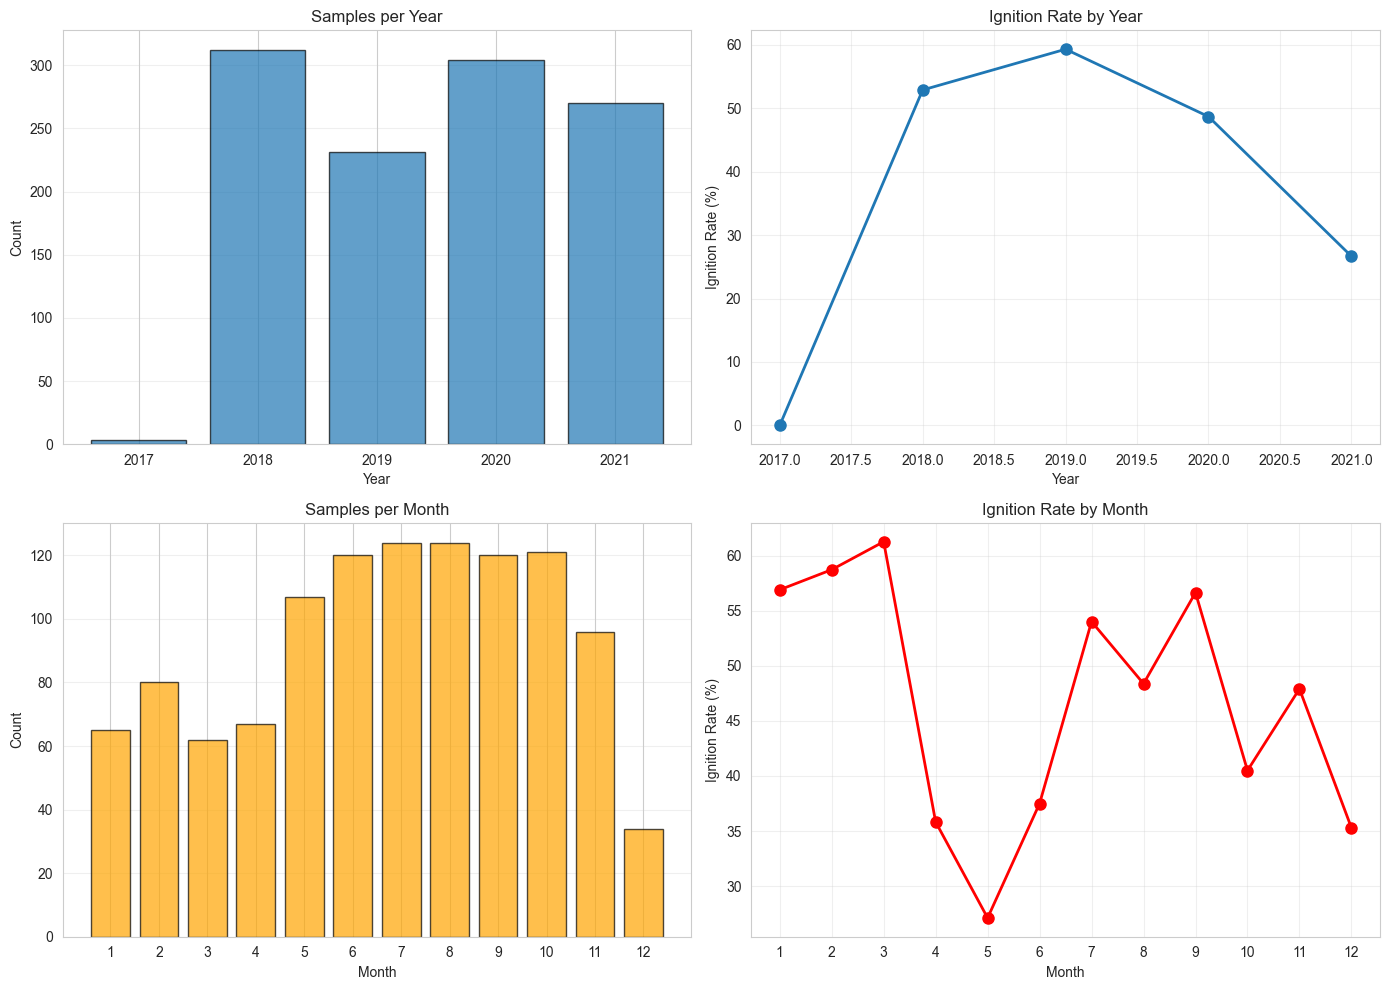

In [22]:
# Temporal distributions (if available)
if 'year' in df.columns or 'month' in df.columns:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Year distribution
    if 'year' in df.columns:
        year_counts = df['year'].value_counts().sort_index()
        axes[0, 0].bar(year_counts.index, year_counts.values, alpha=0.7, edgecolor='black')
        axes[0, 0].set_title('Samples per Year')
        axes[0, 0].set_xlabel('Year')
        axes[0, 0].set_ylabel('Count')
        axes[0, 0].grid(True, alpha=0.3, axis='y')
        
        # Ignition rate by year
        if 'ignition' in df.columns:
            ignition_by_year = df.groupby('year')['ignition'].mean() * 100
            axes[0, 1].plot(ignition_by_year.index, ignition_by_year.values, marker='o', linewidth=2, markersize=8)
            axes[0, 1].set_title('Ignition Rate by Year')
            axes[0, 1].set_xlabel('Year')
            axes[0, 1].set_ylabel('Ignition Rate (%)')
            axes[0, 1].grid(True, alpha=0.3)
    
    # Month distribution
    if 'month' in df.columns:
        month_counts = df['month'].value_counts().sort_index()
        axes[1, 0].bar(month_counts.index, month_counts.values, alpha=0.7, edgecolor='black', color='orange')
        axes[1, 0].set_title('Samples per Month')
        axes[1, 0].set_xlabel('Month')
        axes[1, 0].set_ylabel('Count')
        axes[1, 0].set_xticks(range(1, 13))
        axes[1, 0].grid(True, alpha=0.3, axis='y')
        
        # Ignition rate by month
        if 'ignition' in df.columns:
            ignition_by_month = df.groupby('month')['ignition'].mean() * 100
            axes[1, 1].plot(ignition_by_month.index, ignition_by_month.values, marker='o', linewidth=2, markersize=8, color='red')
            axes[1, 1].set_title('Ignition Rate by Month')
            axes[1, 1].set_xlabel('Month')
            axes[1, 1].set_ylabel('Ignition Rate (%)')
            axes[1, 1].set_xticks(range(1, 13))
            axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No temporal columns (year, month) found")


## 5. Feature Statistics


In [23]:
# Embedding statistics
if len(embedding_cols) > 0:
    print("="*70)
    print("EMBEDDING FEATURES STATISTICS")
    print("="*70)
    
    embedding_matrix = df[embedding_cols].values
    print(f"Embedding matrix shape: {embedding_matrix.shape}")
    print(f"Min: {embedding_matrix.min():.4f}")
    print(f"Max: {embedding_matrix.max():.4f}")
    print(f"Mean: {embedding_matrix.mean():.4f}")
    print(f"Std: {embedding_matrix.std():.4f}")
    
    # Check for missing values
    missing = df[embedding_cols].isna().sum().sum()
    print(f"Missing values: {missing:,}")
    
    # Sample a few dimensions
    print(f"\nSample embedding dimensions (first 5):")
    for i in range(min(5, len(embedding_cols))):
        col = embedding_cols[i]
        print(f"  {col}: mean={df[col].mean():.4f}, std={df[col].std():.4f}")
else:
    print("No embedding columns found")


EMBEDDING FEATURES STATISTICS
Embedding matrix shape: (1120, 2048)
Min: 0.0000
Max: 6.7828
Mean: 0.2329
Std: 0.3739
Missing values: 0

Sample embedding dimensions (first 5):
  embedding_0: mean=0.0748, std=0.0754
  embedding_1: mean=0.3237, std=0.2348
  embedding_2: mean=0.0801, std=0.0888
  embedding_3: mean=0.1071, std=0.1209
  embedding_4: mean=0.0435, std=0.0979


In [24]:
# Temporal feature statistics
if len(temporal_cols) > 0:
    print("="*70)
    print("TEMPORAL FEATURES")
    print("="*70)
    print(df[temporal_cols].describe())
    
    print(f"\nUnique values:")
    for col in temporal_cols:
        print(f"  {col}: {df[col].nunique()} unique values")
else:
    print("No temporal columns found")


TEMPORAL FEATURES
              year        month  day_of_year  day_of_week
count  1120.000000  1120.000000  1120.000000  1120.000000
mean   2019.469643     6.739286   189.533036     3.012500
std       1.142629     3.061168    93.130842     2.003532
min    2017.000000     1.000000     1.000000     0.000000
25%    2018.000000     5.000000   123.000000     1.000000
50%    2020.000000     7.000000   196.500000     3.000000
75%    2020.000000     9.000000   266.250000     5.000000
max    2021.000000    12.000000   365.000000     6.000000

Unique values:
  year: 5 unique values
  month: 12 unique values
  day_of_year: 352 unique values
  day_of_week: 7 unique values


## 6. Data Quality Checks


In [25]:
# Comprehensive data quality checks
print("="*70)
print("DATA QUALITY CHECKS")
print("="*70)

# Missing values
print(f"\n1. Missing Values:")
missing_summary = df.isna().sum()
missing_cols = missing_summary[missing_summary > 0]
if len(missing_cols) > 0:
    print(f"   Columns with missing values: {len(missing_cols)}")
    print(missing_cols.head(20))
    if len(missing_cols) > 20:
        print(f"   ... and {len(missing_cols) - 20} more")
else:
    print("   ✓ No missing values")

# Duplicates
print(f"\n2. Duplicates:")
duplicate_rows = df.duplicated().sum()
print(f"   Duplicate rows: {duplicate_rows:,}")

if 'filename' in df.columns:
    duplicate_filenames = df['filename'].duplicated().sum()
    print(f"   Duplicate filenames: {duplicate_filenames:,}")

# Infinite values
print(f"\n3. Infinite Values:")
if len(embedding_cols) > 0:
    inf_count = np.isinf(df[embedding_cols].values).sum()
    print(f"   Infinite values in embeddings: {inf_count:,}")

if 'log_burned_area' in df.columns:
    inf_target = np.isinf(df['log_burned_area']).sum()
    print(f"   Infinite values in log_burned_area: {inf_target:,}")

# Matched files
if 'matched' in df.columns:
    print(f"\n4. File Matching:")
    matched_count = df['matched'].sum() if df['matched'].dtype == bool else (df['matched'] == True).sum()
    print(f"   Matched to .tif files: {matched_count:,} ({matched_count/len(df)*100:.1f}%)")
    print(f"   Not matched: {len(df) - matched_count:,} ({(len(df) - matched_count)/len(df)*100:.1f}%)")


DATA QUALITY CHECKS

1. Missing Values:
   Columns with missing values: 9
event_id       1120
tile           1120
tif_band_1       38
tif_band_2       38
tif_band_3       38
tif_band_4       57
tif_band_5       57
tif_band_16       7
tif_band_23     684
dtype: int64

2. Duplicates:
   Duplicate rows: 0
   Duplicate filenames: 0

3. Infinite Values:
   Infinite values in embeddings: 0
   Infinite values in log_burned_area: 0

4. File Matching:
   Matched to .tif files: 1,120 (100.0%)
   Not matched: 0 (0.0%)


## 7. Feature-Target Relationships


FEATURE-TARGET RELATIONSHIPS


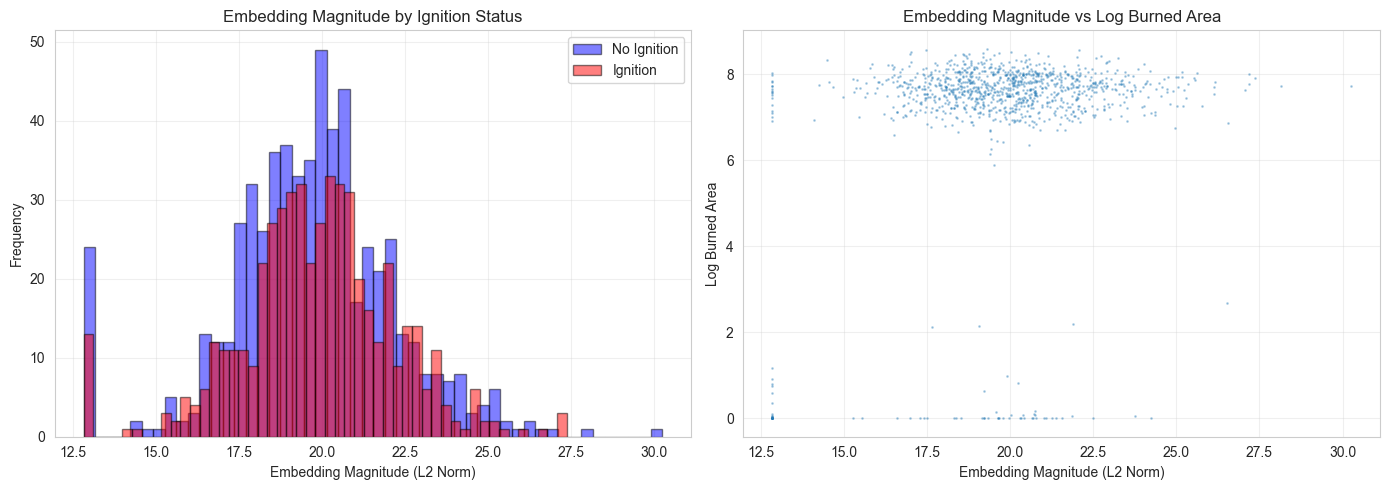


Embedding Magnitude Statistics:
  Overall mean: 19.7786
  Mean (no ignition): 19.7039
  Mean (ignition): 19.8643


In [26]:
# Analyze relationships between features and targets
print("="*70)
print("FEATURE-TARGET RELATIONSHIPS")
print("="*70)

# Embedding magnitude vs targets
if len(embedding_cols) > 0 and 'ignition' in df.columns:
    embedding_norms = np.linalg.norm(df[embedding_cols].values, axis=1)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Embedding magnitude by ignition status
    ignition_0_norms = embedding_norms[df['ignition'] == 0]
    ignition_1_norms = embedding_norms[df['ignition'] == 1]
    
    axes[0].hist(ignition_0_norms, bins=50, alpha=0.5, label='No Ignition', color='blue', edgecolor='black')
    if len(ignition_1_norms) > 0:
        axes[0].hist(ignition_1_norms, bins=50, alpha=0.5, label='Ignition', color='red', edgecolor='black')
    axes[0].set_title('Embedding Magnitude by Ignition Status')
    axes[0].set_xlabel('Embedding Magnitude (L2 Norm)')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Embedding magnitude vs log_burned_area
    if 'log_burned_area' in df.columns:
        axes[1].scatter(embedding_norms, df['log_burned_area'], alpha=0.3, s=1)
        axes[1].set_title('Embedding Magnitude vs Log Burned Area')
        axes[1].set_xlabel('Embedding Magnitude (L2 Norm)')
        axes[1].set_ylabel('Log Burned Area')
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    print(f"\nEmbedding Magnitude Statistics:")
    print(f"  Overall mean: {embedding_norms.mean():.4f}")
    if 'ignition' in df.columns:
        print(f"  Mean (no ignition): {ignition_0_norms.mean():.4f}")
        if len(ignition_1_norms) > 0:
            print(f"  Mean (ignition): {ignition_1_norms.mean():.4f}")


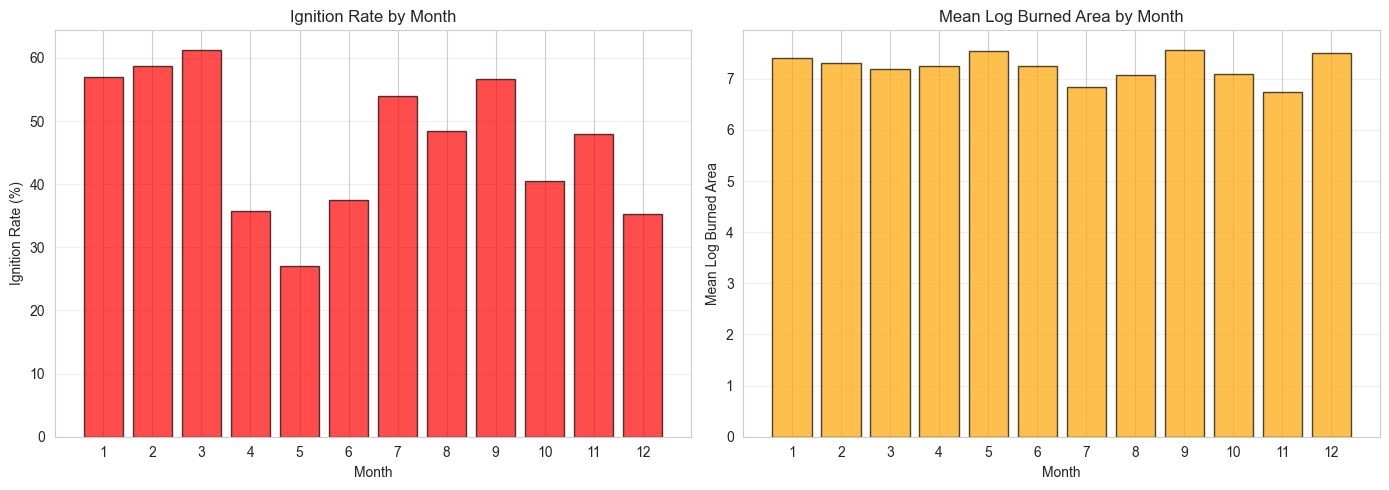

In [27]:
# Temporal patterns in targets
if 'month' in df.columns and 'ignition' in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Ignition rate by month
    ignition_by_month = df.groupby('month')['ignition'].agg(['mean', 'count'])
    ignition_by_month['mean'] *= 100
    
    axes[0].bar(ignition_by_month.index, ignition_by_month['mean'], alpha=0.7, edgecolor='black', color='red')
    axes[0].set_title('Ignition Rate by Month')
    axes[0].set_xlabel('Month')
    axes[0].set_ylabel('Ignition Rate (%)')
    axes[0].set_xticks(range(1, 13))
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Log burned area by month
    if 'log_burned_area' in df.columns:
        area_by_month = df.groupby('month')['log_burned_area'].mean()
        axes[1].bar(area_by_month.index, area_by_month.values, alpha=0.7, edgecolor='black', color='orange')
        axes[1].set_title('Mean Log Burned Area by Month')
        axes[1].set_xlabel('Month')
        axes[1].set_ylabel('Mean Log Burned Area')
        axes[1].set_xticks(range(1, 13))
        axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()


## 8. Sample Data


In [28]:
# Display sample rows (metadata + targets only, not all embeddings)
display_cols = metadata_cols + temporal_cols + target_cols
if len(display_cols) > 0:
    print("="*70)
    print("SAMPLE DATA (Metadata, Temporal, and Targets)")
    print("="*70)
    print(df[display_cols].head(10))
else:
    print("Sample of all columns:")
    print(df.head(10))


SAMPLE DATA (Metadata, Temporal, and Targets)
         filename        date  event_id  tile  matched  year  month  \
0  2018-01-01.tif  2018-01-01       NaN   NaN     True  2018      1   
1  2018-01-02.tif  2018-01-02       NaN   NaN     True  2018      1   
2  2018-01-03.tif  2018-01-03       NaN   NaN     True  2018      1   
3  2018-01-04.tif  2018-01-04       NaN   NaN     True  2018      1   
4  2018-01-05.tif  2018-01-05       NaN   NaN     True  2018      1   
5  2018-01-06.tif  2018-01-06       NaN   NaN     True  2018      1   
6  2018-01-07.tif  2018-01-07       NaN   NaN     True  2018      1   
7  2018-01-08.tif  2018-01-08       NaN   NaN     True  2018      1   
8  2018-01-09.tif  2018-01-09       NaN   NaN     True  2018      1   
9  2018-01-10.tif  2018-01-10       NaN   NaN     True  2018      1   

   day_of_year  day_of_week  ignition  burned_area  log_burned_area  
0            1            0         0  2518.668457         7.831883  
1            2            1     

In [29]:
# Show examples with and without ignition
if 'ignition' in df.columns:
    print("="*70)
    print("EXAMPLES: Samples WITH Ignition")
    print("="*70)
    ignition_samples = df[df['ignition'] == 1]
    if len(ignition_samples) > 0:
        display_cols_sample = [c for c in display_cols if c in ignition_samples.columns]
        print(ignition_samples[display_cols_sample].head(5))
    else:
        print("No samples with ignition found")
    
    print(f"\n" + "="*70)
    print("EXAMPLES: Samples WITHOUT Ignition")
    print("="*70)
    no_ignition_samples = df[df['ignition'] == 0]
    if len(no_ignition_samples) > 0:
        display_cols_sample = [c for c in display_cols if c in no_ignition_samples.columns]
        print(no_ignition_samples[display_cols_sample].head(5))


EXAMPLES: Samples WITH Ignition
         filename        date  event_id  tile  matched  year  month  \
2  2018-01-03.tif  2018-01-03       NaN   NaN     True  2018      1   
3  2018-01-04.tif  2018-01-04       NaN   NaN     True  2018      1   
4  2018-01-05.tif  2018-01-05       NaN   NaN     True  2018      1   
5  2018-01-06.tif  2018-01-06       NaN   NaN     True  2018      1   
6  2018-01-07.tif  2018-01-07       NaN   NaN     True  2018      1   

   day_of_year  day_of_week  ignition  burned_area  log_burned_area  
2            3            2         1  4532.107422         8.419163  
3            4            3         1  2135.602295         7.666972  
4            5            4         1  2080.947998         7.641059  
5            6            5         1  3453.112549         8.147321  
6            7            6         1  2407.073975         7.786583  

EXAMPLES: Samples WITHOUT Ignition
          filename        date  event_id  tile  matched  year  month  \
0   2018-01-0

## 9. Summary and Next Steps


In [30]:
print("="*70)
print("EXPLORATION SUMMARY")
print("="*70)

print(f"\nDataset Overview:")
print(f"  Total samples: {len(df):,}")
print(f"  Total columns: {len(df.columns)}")
print(f"  Embedding dimensions: {len(embedding_cols)}")
print(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print(f"\nTarget Variables:")
if 'ignition' in df.columns:
    ignition_rate = df['ignition'].mean() * 100
    print(f"  Ignition (P-model):")
    print(f"    Positive class: {df['ignition'].sum():,} ({ignition_rate:.2f}%)")
    print(f"    Negative class: {(df['ignition'] == 0).sum():,} ({100-ignition_rate:.2f}%)")
    if ignition_rate < 5:
        print(f"    ⚠️  Highly imbalanced - consider class weights")

if 'log_burned_area' in df.columns:
    print(f"  Log Burned Area (A-model):")
    print(f"    Mean: {df['log_burned_area'].mean():.4f}")
    print(f"    Std: {df['log_burned_area'].std():.4f}")
    print(f"    Range: [{df['log_burned_area'].min():.4f}, {df['log_burned_area'].max():.4f}]")

print(f"\nFeatures:")
print(f"  Embedding features: {len(embedding_cols)}")
print(f"  Temporal features: {len(temporal_cols)}")
print(f"  Metadata columns: {len(metadata_cols)}")

if 'matched' in df.columns:
    matched_pct = (df['matched'].sum() if df['matched'].dtype == bool else (df['matched'] == True).sum()) / len(df) * 100
    print(f"\nData Quality:")
    print(f"  Files matched to .tif: {matched_pct:.1f}%")

print(f"\n" + "="*70)
print("NEXT STEPS")
print("="*70)
print("""
1. **Split Data**:
   python src/data/split_data.py --input-file data/processed/features.csv

2. **Get Feature List**:
   python scripts/get_feature_list.py

3. **Train P-model** (ignition probability):
   python src/models/train_model.py \\
       --features <feature-list> \\
       --target-col ignition \\
       --model-type classifier

4. **Train A-model** (conditional burned area):
   python src/models/train_model.py \\
       --features <feature-list> \\
       --target-col log_burned_area \\
       --model-type regressor
""")
print("="*70)


EXPLORATION SUMMARY

Dataset Overview:
  Total samples: 1,120
  Total columns: 2083
  Embedding dimensions: 2048
  Memory usage: 17.90 MB

Target Variables:
  Ignition (P-model):
    Positive class: 522 (46.61%)
    Negative class: 598 (53.39%)
  Log Burned Area (A-model):
    Mean: 7.2036
    Std: 1.7993
    Range: [0.0000, 8.5884]

Features:
  Embedding features: 2048
  Temporal features: 4
  Metadata columns: 5

Data Quality:
  Files matched to .tif: 100.0%

NEXT STEPS

1. **Split Data**:
   python src/data/split_data.py --input-file data/processed/features.csv

2. **Get Feature List**:
   python scripts/get_feature_list.py

3. **Train P-model** (ignition probability):
   python src/models/train_model.py \
       --features <feature-list> \
       --target-col ignition \
       --model-type classifier

4. **Train A-model** (conditional burned area):
   python src/models/train_model.py \
       --features <feature-list> \
       --target-col log_burned_area \
       --model-type regr